In [1]:
# Import libraries

import numpy              as np
import matplotlib.pyplot  as plt
import matplotlib.patches as patches
import emcee
from scipy       import stats
from scipy.stats import norm

In [2]:
# Use LaTeX

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"]
})

In [3]:
# Load data

data = np.load('transient.npy')

T  = data[:,0]
F  = data[:,1]
eF = data[:,2]

del data

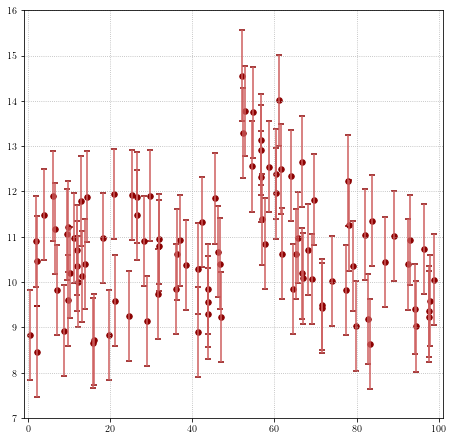

In [98]:
# Take a look at the data

fig , ax = plt.subplots(figsize=(7.5,7.5))

ax.set_xlim(-1,101)
ax.set_ylim(7,16)
ax.grid(ls=':')

for i in range(len(T)):                                                       #for t, f, ef in zip(T, F, eF):
    ax.vlines(T[i], ymin=F[i]-eF[i], ymax=F[i]+eF[i], color='indianred' )          #ax.vlines( t, ymin=t-ef, ymax=t+ef)
ax.scatter(T, F + eF, color='darkred', s=30, marker='_')
ax.scatter(T, F - eF, color='darkred', s=30, marker='_')
ax.scatter(T, F, color='darkred', s=30, marker='o') # , label='')

t_lin = np.linspace(0,100, 10000)
y_lin = event(x0, t_lin)

# ax.plot(t_lin, y_lin, color='lightskyblue')

In [110]:
# define all the functions

# our model for the transient event is:   f(t) =  t > t0 : b  ;  t <= t0 : b + c e^( -a(t-t0) )
# the unknown parameters are:                x = [a, b, c, t0] 
# the functional shape f(t;x) of the transient event:

def event(x, t):  
    return np.where( t > x[3] , x[1] + x[2] * np.exp( -x[0]*(t-x[3]) ) , x[1] )

# the chosen priors on the parameters x:   # SOMETHING IS WRONG

def prior(x): 
    prior_a  = stats.loguniform.pdf(x[0], -5, 5)         # if -5 < lna < +5  returns 1/a,   0 if else  # np.exp( stats.uniform.pdf(np.log(x[0]), loc=-5, scale=5) ) / x[0]
    prior_b  = stats.uniform.pdf(x[1], loc=0, scale=50 ) # if  0 < b   < 50  returns 1/50,  0 if else
    prior_c  = stats.uniform.pdf(x[2], loc=0, scale=50 ) # if  0 < c   < 50  returns 1/50,  0 if else
    prior_t0 = stats.uniform.pdf(x[3], loc=0, scale=100) # if  0 < t0  < 100 returns 1/100, 0 if else
    return prior_a * prior_b * prior_c * prior_t0

# likelihood = prod_data   exp( -1/2 ( f_data - f(t_data) )^2 / f_err^2 ) * const
# the likelihood function given the data: t, f; remember homoscedastic errors: ef.

def likelihood(x, t, f, ef):                               
    return np.prod( np.exp( 1/2 * ( f - event(x, t) )**2 / ef**2 ) ) 

# the posterior pdf: multiply the likelihood by the priors.

def posterior(x, t, f, ef):                                       
    return likelihood(x, t, f, ef) * prior(x)

# Do this again but directly with the logs:

# logarithm of the prior of the parameters x:

def log_prior(x):
    if -5 < np.log(x[0]) < 5 and 0 < x[1] < 50 and 0 < x[2] < 50 and 0 < x[3] < 100 :
        return 0.
    return -np.inf

# logarithm of the posterior pdf:

def logposter(x, t, f, ef):
    return  - 1/2 * np.sum( ( f - event(x, t) )**2 / ef**2 + np.log(ef**2) ) + log_prior(x)


wrong = '''
def logposter(x, t, f, ef):
    logprior = np.log( prior(x) )
    if not np.isfinite(logprior): # if log(prior) is infinite (if prior is 0), return -infinity
        return -np.inf
    return  - 1/2 * np.sum( ( f - event(x, t) )**2 / ef**2 + np.log(ef**2) ) + logprior
'''

In [120]:
# Monte Carlo Markov Chain

# number of model parameters x
n_dim     = 4     

# number of MCMC walkers
n_walkers = 24

# burn-in period to let chains stabilize
n_burnin  = 1000  

# number of MCMC steps to take for each walker
n_steps   = 10000  

# initialize parameters x 
# np.random.seed(0)
x0 = np.array( [0.1,10,5,50] )
starting_guesses = np.tile( x0, (n_walkers,1) )
for i in range(n_walkers):
    for j in range(n_dim):
        starting_guesses[i,j] += x0[j] * np.random.random() / 10.
# np.random.random((n_walkers, n_dim))

# run the actual MCMC to sample the log posterior
sampler = emcee.EnsembleSampler(n_walkers, n_dim, logposter, args=(T,F,eF))
sampler.run_mcmc(starting_guesses, n_steps, progress=True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim); throw-out the burn-in points and reshape:
MCMC_trace = sampler.chain[:, n_burnin:, :].reshape(-1, n_dim)
#MCMC_trace = sampler.chain[:, :, :].reshape(-1, n_dim)



  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\andre\AppData\Local\Temp\ipykernel_3732\3310575388.py:35: RuntimeWarning: invalid value encountered in log
  if -5 < np.log(x[0]) < 5 and 0 < x[1] < 50 and 0 < x[2] < 50 and 0 < x[3] < 100 :
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1446.35it/s]


In [121]:
MCMC = sampler.get_chain()
print(MCMC.shape)
print(MCMC_trace.shape)

# print(starting_guesses)

(10000, 24, 4)
(216000, 4)


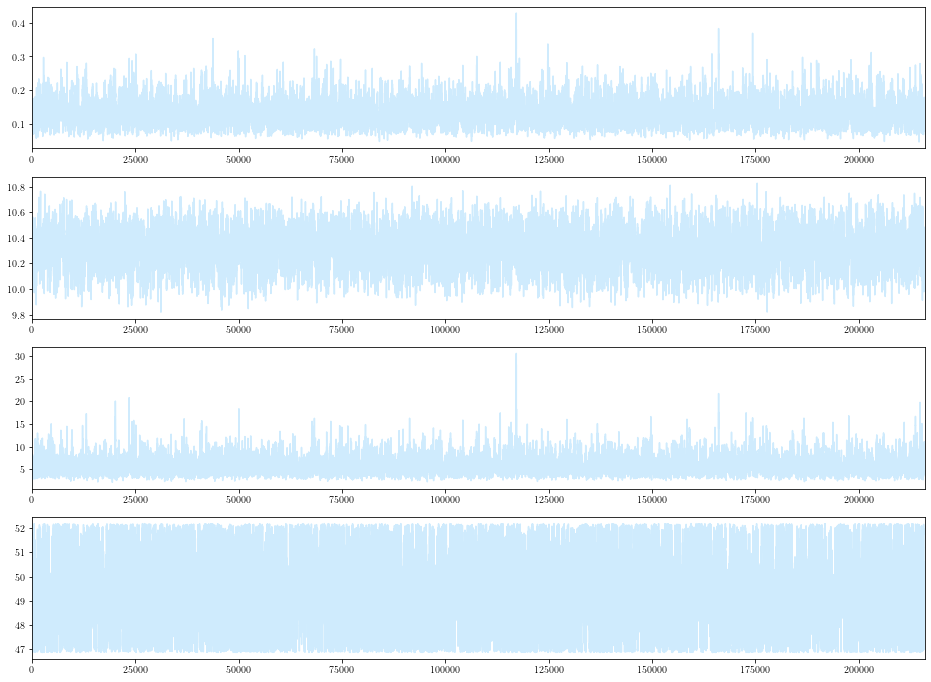

In [122]:
# Plot the results for the MCMC

fig , ax = plt.subplots(4,1, figsize=(16,12))

ax = ax.reshape(4)

# fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

M = np.size(MCMC_trace[:,0])
# chain_a  = MCMC_trace[:,0]
# chain_b  = MCMC_trace[:,1]
# chain_c  = MCMC_trace[:,2]
# chain_t0 = MCMC_trace[:,3]

for i in range(n_dim):
    # counts, bins, _ = ax[i].hist(MCMC_trace[:,i], bins=10, density=True, color='lightskyblue', histtype='step')
    ax[i].set_xlim(0,M)
    ax[i].plot(range(M), MCMC_trace[:,i], color='lightskyblue', alpha=0.4)